In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys, os
import h5py
sys.path.append('../')
import analysis_utils as utils

from matplotlib.ticker import LogLocator, NullFormatter, MultipleLocator
yale_colors = ['#00356b', '#286dc0', '#63aaff', '#4a4a4a']
utils.load_plotting_setting()

from scipy.signal import savgol_filter, medfilt

import importlib
importlib.reload(utils)

In [4]:
data_dir = '/home/yt388/microspheres/impulse_analysis/data_processed'

# file = '/Users/yuhan/work/nanospheres/data/dm_data_processed/sphere_20250103/sphere_20250103_recon_all.h5py'
file = f'{data_dir}/sphere_20250103_recon_all.h5py'
with h5py.File(file, 'r') as fout:
    g = fout['recon_data_all']
    hist = g['hist'][:]
    n_window = g['hist'].attrs['n_windows']
    scaling = g['hist'].attrs['scaling']

    rate_all = g['rate_hist'][:]
    rate_all_err = g['rate_hist_err'][:]
    bc = g['bc'][:]

    time_all = g.attrs['time_hours']

    fout.close()

# file = '/Users/yuhan/work/nanospheres/data/pulse_calibration_processed/sphere_20250103_calibration_all.h5py'
file = f'{data_dir}/sphere_20250103_calibration_all.h5py'
with h5py.File(file, 'r') as fout:
    g = fout['calibration_data_processed']
    eff_coefs = g['sig_efficiency_fit_params'][:]

    fout.close()

In [6]:
from scipy.special import erf
def func2(x, z, f):
    return 0.5 * erf((x - z) * f) + 0.5

def expo_corrected(x, b, xi, eff_coefs=None):
    # Re-normalize exponential after applying efficiency correction 
    # and truncate from below
    xx = np.linspace(0, 50000, 50000)

    if eff_coefs is not None:
        eff_xx = func2(xx, *eff_coefs)
        expo_eff_truncated = eff_xx * np.exp(-1 * (xx) / xi) / xi
    else:
        expo_eff_truncated = np.exp(-1 * (xx) / xi) / xi
    expo_eff_truncated[xx < b] = 0

    expo_corrected_norm = np.trapz(expo_eff_truncated, xx)

    x = np.asarray(x)
    if eff_coefs is not None:
        eff_x = func2(x, *eff_coefs)
        ret = eff_x * np.exp(-1 * (x) / xi) / xi
    else:
        ret = np.exp(-1 * (x) / xi) / xi
    ret[x < b] = 0

    if ret.size == 1:
        return ret[0] / expo_corrected_norm
    else:
        return ret / expo_corrected_norm

def half_gaus_mod(x, mu, m, n):
    xx = np.linspace(0, 50000, 50000)
    sigma = m * xx + n
    _norm = np.trapz((1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-1 * (xx - mu)**2 / (2 * sigma**2)), xx)

    sigma_x = m * x + n
    return (1 / (np.sqrt(2 * np.pi) * sigma_x)) * np.exp(-1 * (x - mu)**2 / (2 * sigma_x**2)) / _norm

def half_gaus_mod_fixed(x, mu, sigma):
    xx = np.linspace(0, 50000, 50000)
    _norm = np.trapz((1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-1 * (xx - mu)**2 / (2 * sigma**2)), xx)

    return (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-1 * (x - mu)**2 / (2 * sigma**2)) / _norm

In [7]:
def nll(alpha, mu, m, n, b, xi, bc, hist, eff_coefs=None):
    idx = bc > 800

    bi = bc[idx]
    ni = hist[idx]

    # Total number of count in the entire range
    ntot = np.sum(hist)

    # Use only the central value of pdf
    # faster and avoid numerical issues from integration
    joint_pdf = alpha * half_gaus_mod(bi, mu, m, n) + (1 - alpha) * expo_corrected(bi, b, xi, eff_coefs=None)
    mui = ntot * joint_pdf * 50


    return np.sum(np.nan_to_num(mui - ni * np.log(mui)))


In [8]:
from scipy.optimize import minimize

ntot = np.sum(hist)
args = (bc, hist, None)
res = minimize(fun=lambda x: nll(*x, *args), x0=[0.999999068, 378, 5.6e-2, 142, 1414, 140],
               method='Nelder-Mead',
               bounds=[(0.99, 1), (0, 500), (0, 0.1), (100, 300), (1000, 1500), (90, 160)],
               options={'disp' : True,
                        'maxiter': 10000,
                        'maxfev': 10000,
                        'adaptive': True,
                        'fatol': 0.0001,
                        }
               )

# res = minimize(fun=lambda x: nll(*x, *args), x0=[0.999999, 200, 5e-2, 180, 1400, 120],
#                method='COBYQA',
#                bounds=[(0.99, 1), (0, 500), (0, 0.1), (100, 300), (1000, 1600), (90, 160)],
#                tol=1e-6,
#                options={'disp' : True,
#                         'maxiter': 10000,
#                         'maxfev': 10000,
#                         'scale': True,
#                         }
#                )

param_nodm = res.x
nll_nodm   = res.fun

Optimization terminated successfully.
         Current function value: -4346738282.505365
         Iterations: 1303
         Function evaluations: 2256


In [9]:
res.x

array([9.99999447e-01, 3.56746616e+02, 5.79875030e-02, 1.42746398e+02,
       1.47496320e+03, 1.24520579e+02])

In [10]:
def hist_fit_likelihood(bcs, ntot, alpha, mu, m, n, b, xi):
    return ntot * 50 * (alpha * half_gaus_mod(bcs, mu, m, n) + (1 - alpha) * expo_corrected(bcs, b, xi, eff_coefs))

def plot_likelihood_fit(bc, hist, res_x):
    fig, axes = plt.subplots(2, 1, figsize=(7, 8), height_ratios=[4, 1])

    ntot = np.sum(hist)
    alpha, mu, m, n, b, xi = res_x

    idx = bc > 800
    hist_norm = n_window * scaling

    hist_fit_ml = hist_fit_likelihood(bc[idx], np.sum(hist), *res_x)

    ax = axes[0]
    ax.fill_betweenx(np.logspace(-1, 9, 100), 0, 800, color='#B0C4DE', alpha=0.5)
    ax.errorbar(bc[idx], hist[idx], yerr=np.sqrt(hist[idx]), fmt='.', color='#005AB5', alpha=1)

    ax.plot(bc[idx], hist_fit_ml, '--', color='#DC143C', label='Gaussian + exponential (ML)')

    xx2 = np.linspace(820, 10000, 500)
    gaus_hist = ntot * 50 * alpha * half_gaus_mod(xx2, mu, m, n)
    ax.fill_between(xx2, 0, gaus_hist, color='#E1BE6A', alpha=0.25)

    xx1 = np.linspace(b, 10000, 500)
    expo_hist = ntot * 50 * (1 - alpha) * expo_corrected(xx1, b, xi, eff_coefs=None)
    ax.fill_between(xx1, 0, expo_hist, color='#2E8B57', alpha=0.2)

    ax.set_yscale('log')

    ax.set_xlim(0, 6000)
    ax.set_ylim(1e-1, 1e9)

    ax.set_yticks(np.logspace(-1, 9, 11))
    locmin = LogLocator(base=10.0, subs=(0.2, 0.4, 0.6, 0.8), numticks=15)
    ax.xaxis.set_minor_locator(MultipleLocator(500))
    ax.yaxis.set_minor_locator(locmin)
    ax.yaxis.set_minor_formatter(NullFormatter())

    ax.legend(frameon=False)
    ax.set_xticklabels([''])
    ax.set_ylabel('Counts / (50 keV/c)')

    ax = axes[1]
    ax.plot(bc[idx], (hist[idx] - hist_fit_ml) / np.sqrt(hist[idx]), '.', color='#005AB5', markersize=5, label='Gaussian + exponential (ML)')
    ax.fill_betweenx(np.linspace(-1000, 1000, 100), 0, 800, color='#B0C4DE', alpha=0.5)

    ax.set_xlim(0, 6000)
    ax.set_ylim(-150, 150)
    ax.xaxis.set_minor_locator(MultipleLocator(500))
    ax.set_xlabel('Reconstructed amplitude (keV/c)')
    ax.set_ylabel('Residual / $\sigma_{\mathrm{stat}}$')

    fig.suptitle('Sphere 20250103')
    fig.tight_layout()

    return fig, axes

/tmp/tmp.XxIAiEcMUe/ipykernel_4066798/3987666047.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''])
/tmp/tmp.XxIAiEcMUe/ipykernel_4066798/3987666047.py:45: RuntimeWarning: divide by zero encountered in divide
  ax.plot(bc[idx], (hist[idx] - hist_fit_ml) / np.sqrt(hist[idx]), '.', color='#005AB5', markersize=5, label='Gaussian + exponential (ML)')


(<Figure size 700x800 with 2 Axes>,
 array([<Axes: ylabel='Counts / (50 keV/c)'>,
        <Axes: xlabel='Reconstructed amplitude (keV/c)', ylabel='Residual / $\\sigma_{\\mathrm{stat}}$'>],
       dtype=object))

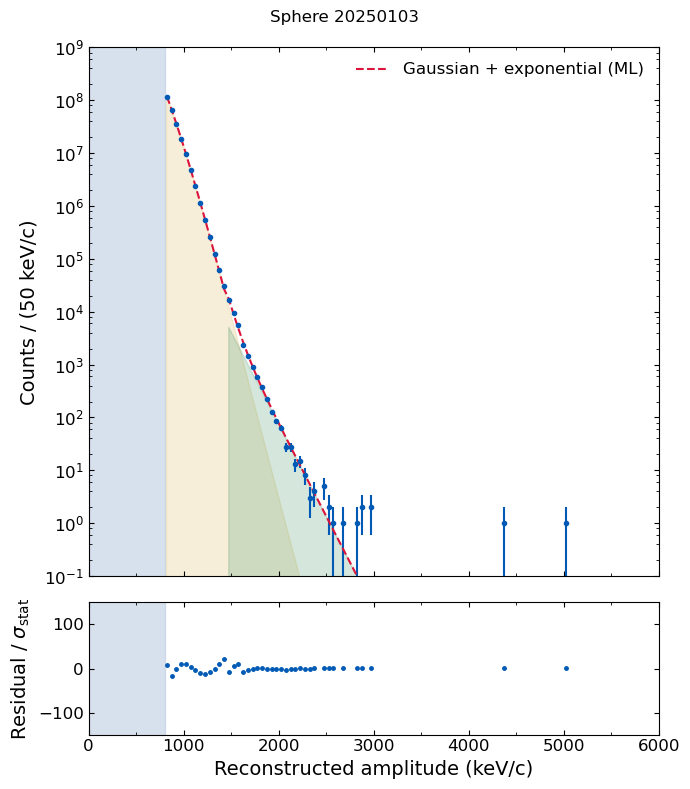

In [11]:
plot_likelihood_fit(bc, hist, res.x)

In [5]:
def smooth_nlls(alpha_list, nlls):
    _res, _alpha = nlls, alpha_list

    for i, nll in enumerate(_res):
        if i == 0:
            continue
        if nll < _res[i-1]:
            if i == (_res.size - 1):
                _res[i] = _res[i - 1]
            else:
                _res[i] = np.interp(_alpha[i], [_alpha[i-1], _alpha[i+1]], [_res[i-1], _res[i+1]])

    return _res

def get_upper_alpha(alpha_list, nlls):
    _nlls = nlls[~np.isnan(nlls)]
    _alpha = alpha_list[~np.isnan(nlls)]

    if _nlls.size == 0:
        return np.nan
    
    # Remove spikes in the nlls using a median filter
    # _nlls = medfilt(_nlls, 3)
    
    idx_ml = np.argmin(_nlls)

    if np.max(_nlls - _nlls[idx_ml]) < 10:
        return np.nan

    # Make sure NLLs are strictly increasing above the
    # maximum likelihood alpha
    idx_search = _alpha >= _alpha[idx_ml]
    if np.sum(idx_search) == 0:
        return np.nan

    # delta_nlls_smoothed = smooth_nlls(_alpha[idx_search], _nlls[idx_search] - _nlls[idx_ml])
    delta_nlls = _nlls[idx_search] - _nlls[idx_ml]

    # return np.interp(3.841, 2*delta_nlls_smoothed, _alpha[idx_search], left=np.nan, right=np.nan)
    return np.interp(3.841, 2*delta_nlls, _alpha[idx_search], left=np.nan, right=np.nan)

def get_alpha_limits(mphi, list_idx=0):
    nlls_file = np.load(fr'{data_dir}/profile_nlls/profile_nlls_{mphi:.0e}_{list_idx}.npz')
    nlls = nlls_file['nll']
    mx_list, alpha_list = nlls_file['mx'], nlls_file['alpha']

    alpha_upper = np.empty(mx_list.size)
    for i in range(mx_list.size):
        alpha_upper[i] = get_upper_alpha(alpha_list, nlls[i])

    return mx_list, alpha_upper, alpha_list, nlls


In [6]:
lim_0_01ev_2 = get_alpha_limits(0.01, 2)
lim_0_1ev_2 = get_alpha_limits(0.1, 2)
lim_1ev_2 = get_alpha_limits(1, 2)
lim_10ev_2 = get_alpha_limits(10, 2)
lim_10ev_3 = get_alpha_limits(10, 3)

In [7]:
outfile_name = 'alpha_limits_all.h5py'
with h5py.File(os.path.join(data_dir, outfile_name), 'w') as fout:
    print(f'Writing file {os.path.join(data_dir, outfile_name)}')

    g = fout.create_group('alpha_lim_95cl')

    g0 = g.create_dataset('mx_gev', data=lim_0_01ev_2[0], dtype=np.float64)

    g1 = g.create_dataset('alpha_lim_0_01ev', data=lim_0_01ev_2[1], dtype=np.float64)
    g2 = g.create_dataset('alpha_lim_0_1ev', data=lim_0_1ev_2[1], dtype=np.float64)
    g3 = g.create_dataset('alpha_lim_1ev', data=lim_1ev_2[1], dtype=np.float64)
    g3 = g.create_dataset('alpha_lim_10ev', data=lim_10ev_2[1], dtype=np.float64)

    fout.close()

Writing file /home/yt388/microspheres/impulse_analysis/data_processed/alpha_limits_all.h5py


In [7]:
mx_list_2 = lim_10ev_2[0]
idx_plot = np.logical_and(mx_list_2 > 1, mx_list_2 < 1e4)

mx_interp = mx_list_2[idx_plot]
mx_plot = np.logspace(-1, 4, 200)

In [ ]:
from scipy.interpolate import Akima1DInterpolator

fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(lim_10ev_3[0], np.nan_to_num(lim_10ev_3[1], nan=1e10), '.-', label='$m_\phi$ = 10 eV', color='#5459a6')
# ax.plot(mx_interp, np.nan_to_num(lim_10ev_2[1][idx_plot], nan=1e10), '.-', label='$m_\phi$ = 10 eV', color='r')
ax.plot(mx_interp, np.nan_to_num(lim_1ev_2[1][idx_plot], nan=1e10), '.-', label='$m_\phi$ = 1 eV', color='#5a7596')
ax.plot(mx_interp, np.nan_to_num(lim_0_1ev_2[1][idx_plot], nan=1e10), '.-', label='$m_\phi$ = 0.1 eV', color='#5f9285')
ax.plot(mx_interp, np.nan_to_num(lim_0_01ev_2[1][idx_plot], nan=1e10), '.-', label='$m_\phi$ = 0.01 eV', color='#65ae75')

# ax.plot(mx_plot, Akima1DInterpolator(mx_interp, np.nan_to_num(lim_10ev_2[1][idx_plot], nan=1), method='makima')(mx_plot), label='$m_\phi$ = 10 eV', color='#5459a6')
# ax.plot(mx_plot, Akima1DInterpolator(mx_interp, np.nan_to_num(lim_1ev_2[1][idx_plot], nan=1), method='makima')(mx_plot), label='$m_\phi$ = 1 eV', color='#5a7596')
# ax.plot(mx_plot, Akima1DInterpolator(mx_interp, np.nan_to_num(lim_0_1ev_2[1][idx_plot], nan=1), method='makima')(mx_plot), label='$m_\phi$ = 0.1 eV', color='#5f9285')
# ax.plot(mx_plot, Akima1DInterpolator(mx_interp, np.nan_to_num(lim_0_01ev_2[1][idx_plot], nan=1), method='makima')(mx_plot), label='$m_\phi$ = 0.01 eV', color='#65ae75')

plt.xlim(1e0, 1e4)
plt.ylim(1e-8, 1e-3)

plt.yscale('log')
plt.xscale('log')

plt.legend(frameon=False)
plt.xlabel(r'Dark matter mass $M_\chi$ (GeV)')
plt.ylabel(r'95% CL Upper limit on $\alpha_n$')

<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:6: SyntaxWarning: invalid escape sequence '\p'
<>:7: SyntaxWarning: invalid escape sequence '\p'
<>:8: SyntaxWarning: invalid escape sequence '\p'
<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:6: SyntaxWarning: invalid escape sequence '\p'
<>:7: SyntaxWarning: invalid escape sequence '\p'
<>:8: SyntaxWarning: invalid escape sequence '\p'
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_42611/1935816843.py:4: SyntaxWarning: invalid escape sequence '\p'
  ax.plot(lim_10ev_3[0], np.nan_to_num(lim_10ev_3[1], nan=1e10), '.-', label='$m_\phi$ = 10 eV', color='#5459a6')
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_42611/1935816843.py:6: SyntaxWarning: invalid escape sequence '\p'
  ax.plot(mx_interp, np.nan_to_num(lim_1ev_2[1][idx_plot], nan=1e10), '.-', label='$m_\phi$ = 1 eV', color='#5a7596')
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_42611/1935816843.py:7: SyntaxWarning: invalid escape sequ

NameError: name 'plt' is not defined

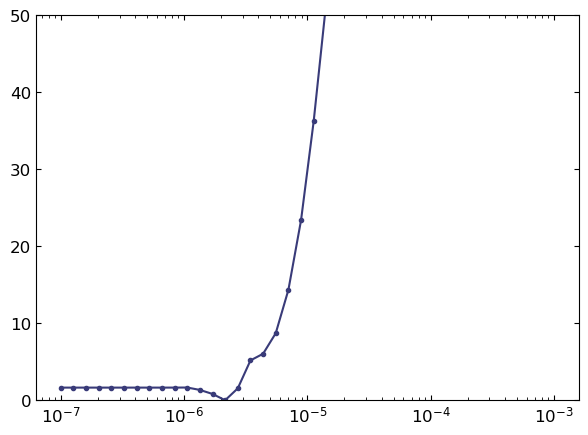

In [39]:
plt.plot(lim_10ev_2[-2], lim_10ev_2[-1][12] - np.min(lim_10ev_2[-1][12]), '.-')

plt.ylim(0, 50)
# plt.xlim(1e-7, 1e-6)
plt.xscale('log')

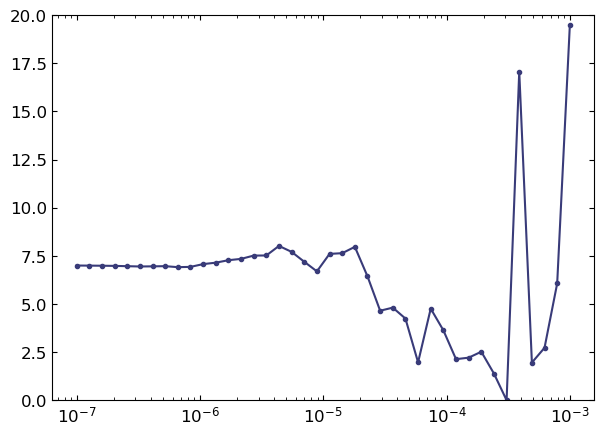

In [40]:
plt.plot(lim_0_01ev_2[-2], lim_0_01ev_2[-1][0] - np.min(lim_0_01ev_2[-1][0]), '.-')
# plt.plot(lim_0_1ev_2[-2], lim_0_1ev_2[-1][13] - np.min(lim_0_1ev_2[-1][13]), '.-')

plt.ylim(0, 20)
# plt.xlim(1e-7, 1e-6)
plt.xscale('log')